D:\Anaconda\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
D:\Anaconda\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 57 116 117 118 119 124 125 126 127] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\Anaconda\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Original number of features: 128
Number of features after selection: 40
Number of principal components: 12

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy: 0.8944
Precision: 0.9601
Recall: 0.9018
F1 Score: 0.9300
ROC AUC: 0.8975

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.78       220
           1       0.96      0.90      0.93       774

    accuracy                           0.89       994
   macro avg       0.84      0.88      0.86       994
weighted avg       0.91      0.89      0.90       994



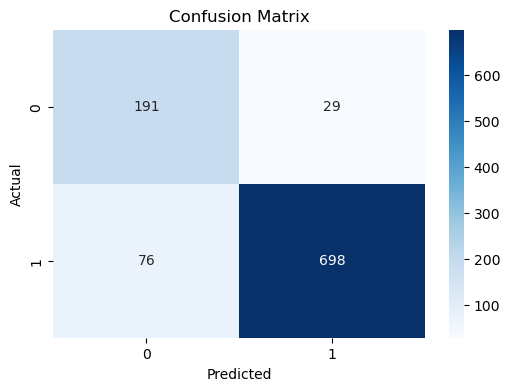

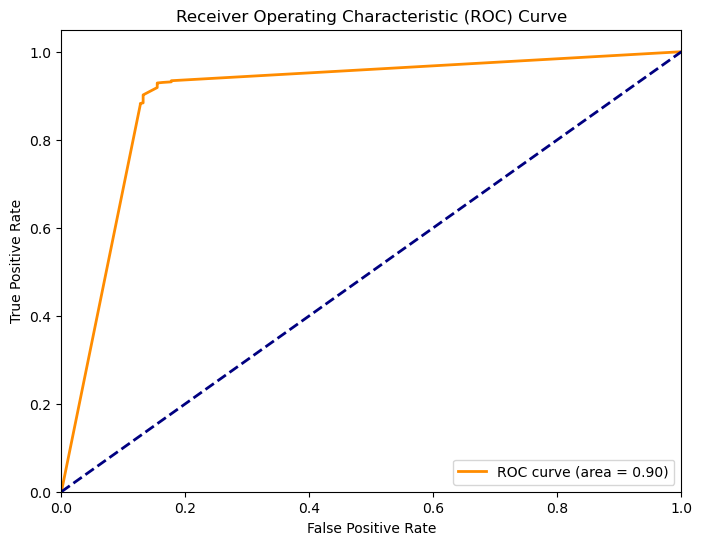


Enhanced Cross-Validation Results:
Accuracy: 0.6172 (±0.0263)
Precision: 0.7854 (±0.0281)
Recall: 0.7023 (±0.0425)
F1 Score: 0.7402 (±0.0218)
ROC AUC: 0.5086 (±0.0598)


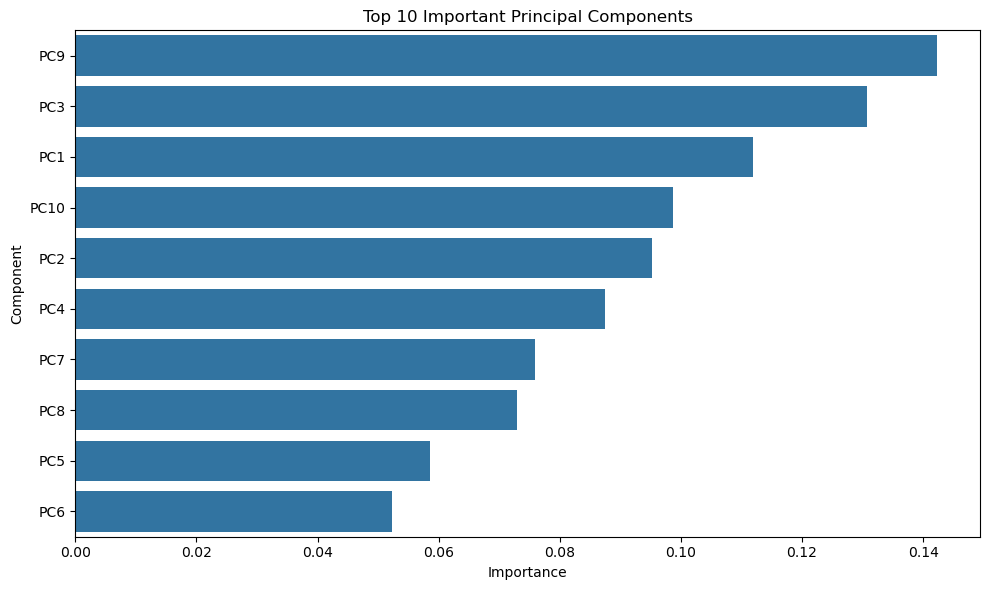


Cross-validation Accuracy: 0.6172 (±0.0263)


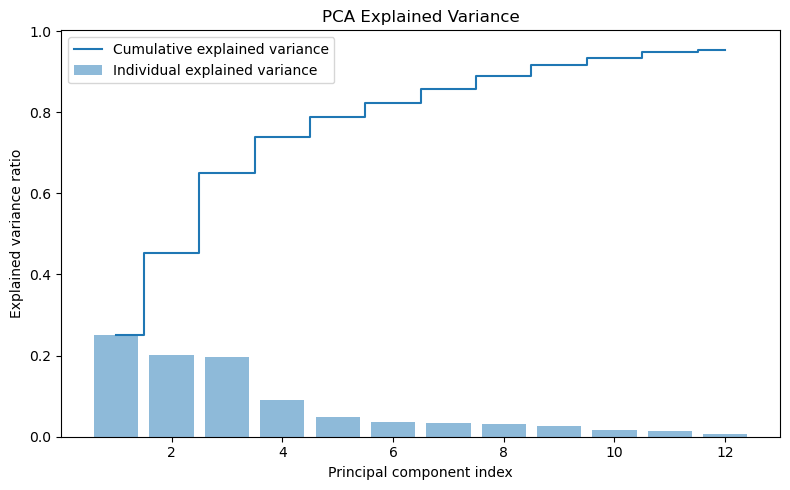

In [5]:
# Final DT code (data1.csv from GitHub)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score)
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_validate

# Load data from GitHub
github_url = "https://raw.githubusercontent.com/haxshita/Power_Grid_Efficiency_Prediction/main/data/data1.csv" 
df = pd.read_csv(github_url)

# Convert target
y = np.where(df.iloc[:, -1] == 'Natural', 0, 1)
X = df.iloc[:, :-1]

# Handle infinities and missing values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Feature transformation
transformer = PowerTransformer(method='yeo-johnson')
X_transformed = transformer.fit_transform(X)

# Feature selection - keep top 40 features
selector = SelectKBest(f_classif, k=40)
X_selected = selector.fit_transform(X_transformed, y)

# Apply PCA to reduce dimensionality while preserving 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_selected)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features after selection: {X_selected.shape[1]}")
print(f"Number of principal components: {X_pca.shape[1]}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

# Advanced oversampling
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

# Optimized Decision Tree with GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_res, y_res)

# Best model
best_dt = grid_search.best_estimator_

# Evaluation
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_value = roc_auc_score(y_test, y_proba)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_value:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Enhanced Cross-Validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(best_dt, X_pca, y, cv=5, scoring=scoring)

print("\nEnhanced Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} (±{cv_results['test_accuracy'].std():.4f})")
print(f"Precision: {cv_results['test_precision'].mean():.4f} (±{cv_results['test_precision'].std():.4f})")
print(f"Recall: {cv_results['test_recall'].mean():.4f} (±{cv_results['test_recall'].std():.4f})")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} (±{cv_results['test_f1'].std():.4f})")
print(f"ROC AUC: {cv_results['test_roc_auc'].mean():.4f} (±{cv_results['test_roc_auc'].std():.4f})")

# Feature Importance (for principal components)
importances = best_dt.feature_importances_
important_components = pd.DataFrame({
    'Component': [f"PC{i+1}" for i in range(len(importances))],
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Component', data=important_components.head(10))
plt.title("Top 10 Important Principal Components")
plt.tight_layout()
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(best_dt, X_pca, y, cv=5, scoring='accuracy')
print(f"\nCross-validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# PCA Explained Variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_,
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_),
         where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('PCA Explained Variance')
plt.tight_layout()
plt.show()